# Exercice 1

## Breast cancer

In cancer detection, we want to minimize incorrect negative predictions (i.e. the sick patient is classified as negative) because this diagnosis could lead to serious health problems. Therefore, the most important metric in the application of cancer detection is the recall which objective is to limit the number of false negatives.

### Load data

In [1]:
from sklearn.datasets import load_breast_cancer

cancer = load_breast_cancer()

In [2]:
cancer['target_names']

array(['malignant', 'benign'], dtype='<U9')

**Target**  
'0' => malignant/sick  
'1' => benign/safe

### Preprocessing

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
df_cancer = pd.DataFrame(data=cancer['data'], columns=cancer['feature_names'])
df_cancer['target'] = cancer['target']

df_train, df_test = train_test_split(df_cancer, test_size=0.2, random_state=42)

df_input_train = df_train.drop(columns=['target'])
df_output_train = df_train['target']


/tmp/ipykernel_56481/2884326544.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [4]:
df_cancer = pd.DataFrame(data=cancer['data'], columns=cancer['feature_names'])
df_cancer['target'] = cancer['target']

df_train, df_test = train_test_split(df_cancer, test_size=0.2, random_state=42)

df_input_train = df_train.drop(columns=['target'])
df_output_train = df_train['target']
df_input_test = df_test.drop(columns=['target'])
df_output_test = df_test['target']


### Training

#### With hand

##### K-NN

In [5]:
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

best_recall = 0

for nb_neighbors in [k for k in range(1, 50)]:
    knn = KNeighborsClassifier(n_neighbors=nb_neighbors)
    knn.fit(df_input_train, df_output_train)
    recalls = cross_val_score(knn, df_input_train, df_output_train, cv=10, scoring='recall')
    recall = recalls.mean()
    if recall > best_recall:
        best_recall = recall
        best_knn = knn
        best_k = nb_neighbors

print(best_k)

y_pred = best_knn.predict(df_input_test)
precision_knn = precision_score(df_output_test, y_pred)
recall_knn = recall_score(df_output_test, y_pred)
f1_knn = f1_score(df_output_test, y_pred)
auc_knn = roc_auc_score(df_output_test, y_pred)

39


##### Logistic regression

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
import itertools
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

best_recall = 0

param_values = {
    'penalty': ['l2'],
    'C': [1e-9, 1e-6, 1e-3, 1, 100, 1000, 10000],
    'max_iter': [10, 100, 1000, 10000, 100000]
}

param_combinations = itertools.product(param_values['C'], param_values['penalty'], param_values['max_iter'])

for C, penalty, max_iter in param_combinations:
    LogReg = LogisticRegression(C=C, penalty=penalty, max_iter=max_iter)
    LogReg.fit(df_input_train, df_output_train)
    recalls = cross_val_score(LogReg, df_input_train, df_output_train, cv=10, scoring='recall')
    recall = recalls.mean()
    if recall > best_recall:
        best_recall = recall
        best_LogReg = LogReg
        best_C = C
        best_penalty = penalty
        best_max_iter = max_iter

y_pred = best_LogReg.predict(df_input_test)
precision_LogReg = precision_score(df_output_test, y_pred)
recall_LogReg = recall_score(df_output_test, y_pred)
f1_LogReg = f1_score(df_output_test, y_pred)
auc_LogReg = roc_auc_score(df_output_test, y_pred)

In [7]:
print(best_C, best_penalty, best_max_iter)

1e-09 l2 100


In [8]:

results = pd.DataFrame(columns=["Model", "Precision", "Recall", "f1-score", "AUC"])
results.loc[0] = ["K-NN", f"{precision_knn:.3f}", f"{recall_knn:.3f}", f"{f1_knn:.3f}", f"{auc_knn:.3f}"]
results.loc[1] = ["Logistic regression", f"{precision_LogReg:.3f}", f"{recall_LogReg:.3f}", f"{f1_LogReg:.3f}", f"{auc_LogReg:.3f}"]

print(results.to_string(index=False))


              Model Precision Recall f1-score   AUC
               K-NN     0.922  1.000    0.959 0.930
Logistic regression     0.623  1.000    0.768 0.500


#### With GridSearchCV

In [9]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

grid_knn = {
    'n_neighbors' : [k for k in range(1, 50)]
}

grid_log_reg = {
    'penalty': ['l2'],
    'C': [1e-9, 1e-6, 1e-3, 1, 100, 1000, 10000],
    'max_iter': [10, 100, 1000, 10000, 100000]
}

models_name = ['K-NN (recall)', 'K-NN (default)', 'Logistic regression (recall)', 'Logistic regression (default)']
grids = [grid_knn, grid_knn, grid_log_reg, grid_log_reg]
models = [
    GridSearchCV(KNeighborsClassifier(), grid_knn, cv=10, n_jobs=-1, scoring='recall'),
    GridSearchCV(KNeighborsClassifier(), grid_knn, cv=10, n_jobs=-1),
    GridSearchCV(LogisticRegression(), grid_log_reg, cv=10, n_jobs=-1, scoring='recall'),
    GridSearchCV(LogisticRegression(), grid_log_reg, cv=10, n_jobs=-1)
]

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

import warnings
warnings.filterwarnings('ignore')

results = pd.DataFrame(columns=["Model", "Precision", "Recall", "f1-score", "AUC"])

for i, (model_name, model, grid) in enumerate(zip(models_name, models, grids)):
    model.fit(df_input_train, df_output_train)

    precision = precision_score(df_output_test, model.predict(df_input_test))
    recall = recall_score(df_output_test, model.predict(df_input_test))
    f1 = f1_score(df_output_test, model.predict(df_input_test))
    roc_auc = roc_auc_score(df_output_test, model.predict(df_input_test))

    results.loc[i] = [model_name, f"{precision:.3f}", f"{recall:.3f}", f"{f1:.3f}", f"{roc_auc:.3f}"]

In [11]:
for model_name, model in zip(models_name, models):
    print(f"Best parameters for {model_name}: {model.best_params_}")

Best parameters for K-NN (recall): {'n_neighbors': 39}
Best parameters for K-NN (default): {'n_neighbors': 3}
Best parameters for Logistic regression (recall): {'C': 1e-09, 'max_iter': 100, 'penalty': 'l2'}
Best parameters for Logistic regression (default): {'C': 1000, 'max_iter': 10000, 'penalty': 'l2'}


## Results

In [12]:
print(results.to_string(index=False))

                        Model Precision Recall f1-score   AUC
                K-NN (recall)     0.922  1.000    0.959 0.930
               K-NN (default)     0.932  0.958    0.944 0.921
 Logistic regression (recall)     0.623  1.000    0.768 0.500
Logistic regression (default)     0.986  0.986    0.986 0.981


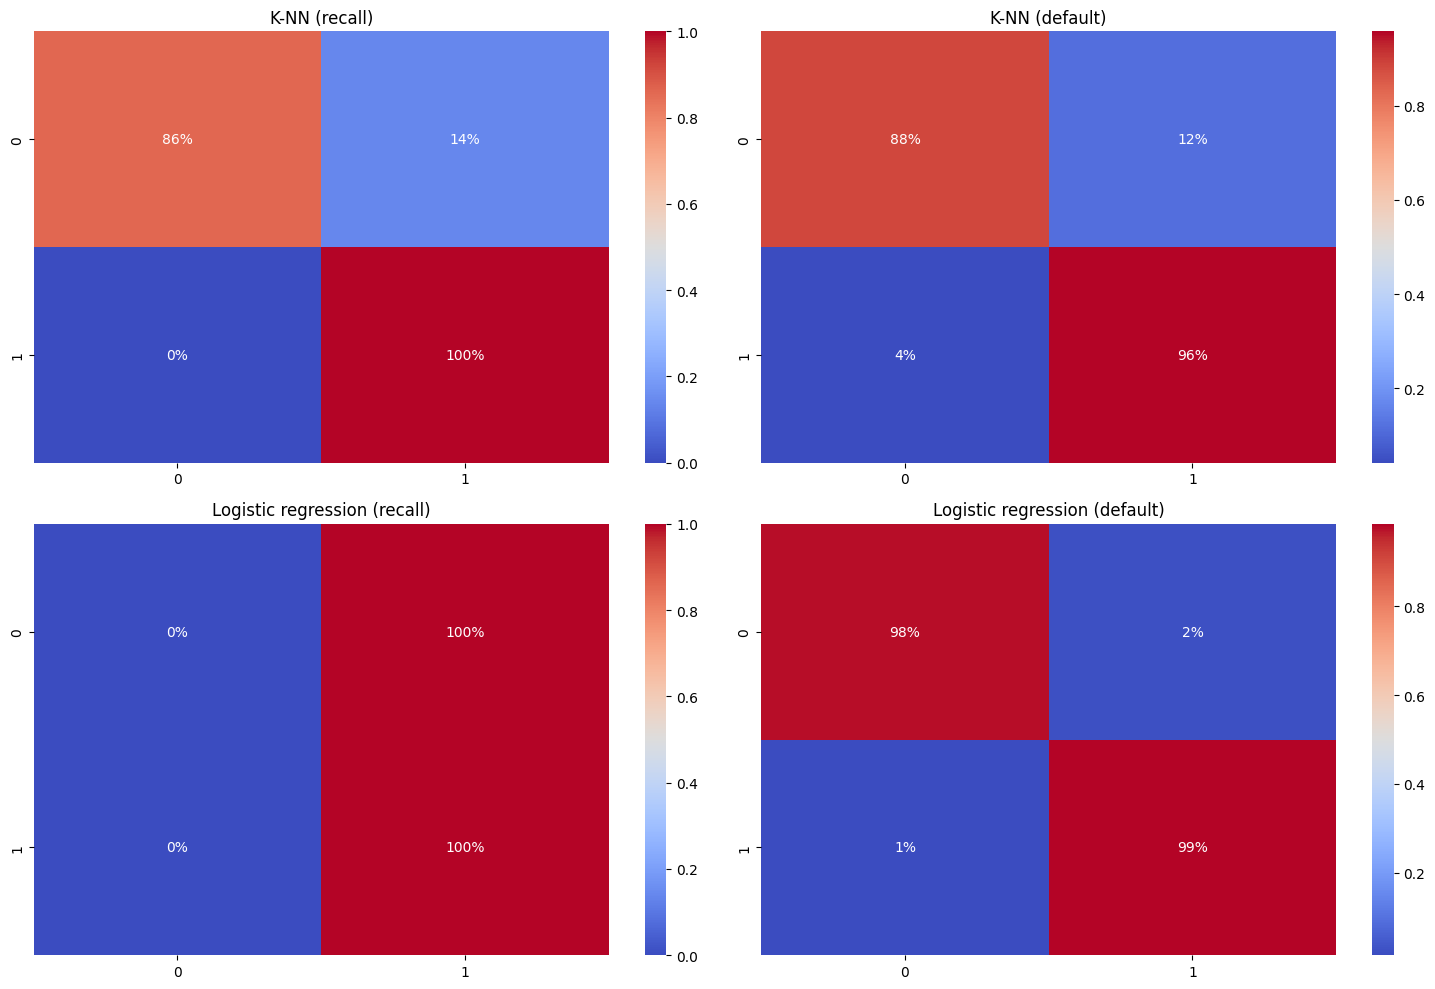

In [13]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

for i, model in enumerate(models):
    y_pred = model.predict(df_input_test)
    cm = confusion_matrix(df_output_test, y_pred)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    sns.heatmap(cm_normalized, annot=True, fmt='.0%', ax=axes[i//2, i%2], cmap='coolwarm')
    axes[i//2, i%2].set_title(models_name[i])
    
plt.tight_layout()
plt.show()


The Logistic regression model (recall) maximize the recall by classificating everything as 1 but has a bad precision.  
We can hesitate between **k-nn (recall)** and **logistic regression (default)** :  
**To decide, we need more precision about the objective of maximisation**

## Boston Housing

### Load data

In [14]:
import mglearn
X, y = mglearn.datasets.load_extended_boston()

### Preprocessing

In [15]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Training

#### With hand

##### Linear Regression

In [16]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_percentage_error

best_r2 = 0

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)
mape_lr = mean_absolute_percentage_error(y_test, y_pred)
r2_lr = r2_score(y_test, y_pred)
mse_lr = np.sqrt(mean_squared_error(y_test, y_pred))


##### Ridge

In [17]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Ridge
import itertools
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_percentage_error

best_r2 = 0

param_values = {
    'alpha': [1e-9, 1e-6, 1e-3, 1, 10, 100, 1000, 10000],
    'max_iter': [10, 100, 1000, 10000, 100000]
}

param_combinations = itertools.product(param_values['alpha'], param_values['max_iter'])

for alpha, max_iter in param_combinations:
    ridge = Ridge(alpha=alpha, max_iter=max_iter)
    ridge.fit(X_train, y_train)
    r2s = cross_val_score(ridge, X_train, y_train, cv=10, scoring='r2')
    r2 = r2s.mean()
    if r2 > best_r2:
        best_r2 = r2
        best_ridge = ridge
        best_alpha = alpha
        best_max_iter = max_iter

print(best_alpha, best_max_iter)

y_pred = best_ridge.predict(X_test)
mape_ridge = mean_absolute_percentage_error(y_test, y_pred)
r2_ridge = r2_score(y_test, y_pred)
mse_ridge = np.sqrt(mean_squared_error(y_test, y_pred))

0.001 10


##### Lasso

In [18]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Lasso
import itertools
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_percentage_error

best_r2 = 0

param_values = {
    'alpha': [1e-9, 1e-6, 1e-3, 1, 10, 100, 1000, 10000],
    'max_iter': [10, 100, 1000, 10000, 100000]
}

param_combinations = itertools.product(param_values['alpha'], param_values['max_iter'])

for alpha, max_iter in param_combinations:
    lasso = Lasso(alpha=alpha, max_iter=max_iter)
    lasso.fit(X_train, y_train)
    r2s = cross_val_score(lasso, X_train, y_train, cv=10, scoring='r2')
    r2 = r2s.mean()
    if r2 > best_r2:
        best_r2 = r2
        best_lasso = lasso
        best_alpha = alpha
        best_max_iter = max_iter

print(best_alpha, best_max_iter)

y_pred = best_lasso.predict(X_test)
mape_lasso = mean_absolute_percentage_error(y_test, y_pred)
r2_lasso = r2_score(y_test, y_pred)
mse_lasso = np.sqrt(mean_squared_error(y_test, y_pred))

0.001 1000


In [19]:
results = pd.DataFrame(columns=["Model", "MAPE", "r2", "MSE"])
results.loc[0] = ["Linear regression", f"{mape_lr:.3f}", f"{r2_lr:.3f}", f"{mse_lr:.2f}"]
results.loc[1] = ["Ridge", f"{mape_ridge:.3f}", f"{r2_ridge:.3f}", f"{mse_ridge:.2f}"]
results.loc[2] = ["Lasso", f"{mape_lasso:.3f}", f"{r2_lasso:.3f}", f"{mse_lasso:.2f}"]

print(results.to_string(index=False))

            Model  MAPE    r2  MSE
Linear regression 0.137 0.806 3.78
            Ridge 0.127 0.817 3.66
            Lasso 0.114 0.840 3.42


#### With GridSearchCV

In [20]:
from sklearn.linear_model import LogisticRegression, Ridge, Lasso
from sklearn.model_selection import GridSearchCV

grid_lr = {}

grid_ridge = {
    'alpha': [1e-9, 1e-6, 1e-3, 1, 10, 100, 1000, 10000],
    'max_iter': [10, 100, 1000, 10000, 100000]
}

grid_lasso = {
    'alpha': [1e-9, 1e-6, 1e-3, 1, 10, 100, 1000, 10000],
    'max_iter': [10, 100, 1000, 10000, 100000]
}

models_name = ['Linear regression', 'Ridge', 'Lasso']
grids = [grid_lr, grid_ridge, grid_lasso]
models = [
    GridSearchCV(LinearRegression(), grid_lr, cv=10, n_jobs=-1),
    GridSearchCV(Ridge(), grid_ridge, cv=10, n_jobs=-1, scoring='r2'),
    GridSearchCV(Lasso(), grid_lasso, cv=10, n_jobs=-1, scoring='r2')
]

In [ ]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_percentage_error

import warnings
warnings.filterwarnings('ignore')

results = pd.DataFrame(columns=["Model", "MAPE", "r2", "MSE"])

for i, (model_name, model, grid) in enumerate(zip(models_name, models, grids)):
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    mse = np.sqrt(mean_squared_error(y_test, y_pred))

    results.loc[i] = [model_name, f"{mape:.3f}", f"{r2:.3f}", f"{mse:.2f}"]

In [22]:
for model_name, model in zip(models_name, models):
    print(f"Best parameters for {model_name}: {model.best_params_}")


Best parameters for Linear regression: {}
Best parameters for Ridge: {'alpha': 0.001, 'max_iter': 10}
Best parameters for Lasso: {'alpha': 0.001, 'max_iter': 1000}


In [23]:
print(results.to_string(index=False))

            Model  MAPE    r2  MSE
Linear regression 0.137 0.806 3.78
            Ridge 0.127 0.817 3.66
            Lasso 0.114 0.840 3.42


Lasso seems to be the model with the highest r² and the lowest MSE. We choose this model.